https://www.kaggle.com/pranavraikokte/covid19-image-dataset

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import importlib
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
# Step 1: Loading in Dataset
ds_directory = '~/9-Projects/ECET380/Covid19-dataset/train'
os.listdir(ds_directory)
ts_directory = '~/9-Projects/ECET380/Covid19-dataset/test'

In [3]:
# Load in ordered dataset
BATCH_SIZE = 16
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)
train_set = image_dataset_from_directory(ds_directory,
                        shuffle=True,
                        validation_split=0.2,
                        subset="training",
                        seed=123,
                        batch_size=BATCH_SIZE,
                        image_size=IMG_SIZE,
                        labels="inferred",
                        label_mode='int')


Found 181 files belonging to 2 classes.
Using 145 files for training.


In [4]:
val_set = image_dataset_from_directory(ds_directory,
                        shuffle=True,
                        validation_split=0.2,
                        subset="validation",
                        seed=123,
                        batch_size=BATCH_SIZE,
                        image_size=IMG_SIZE,
                        labels="inferred",
                        label_mode='int')

Found 181 files belonging to 2 classes.
Using 36 files for validation.


In [5]:
test_set = image_dataset_from_directory(ts_directory,
                        shuffle=True,
                        batch_size=BATCH_SIZE,
                        image_size=IMG_SIZE,
                        labels="inferred",
                        label_mode='int')

Found 46 files belonging to 2 classes.


In [6]:
train_set.class_names

['Covid', 'Normal']

In [7]:
dataset_size = 181
batch_size = BATCH_SIZE

def preprocess(image, label):
    # resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.efficientnet.preprocess_input(image)
    return final_image, label

train_set = train_set.shuffle(1000).repeat(4)
train_set = train_set.map(preprocess).prefetch(1)
val_set = val_set.map(preprocess).prefetch(1)
test_set = test_set.map(preprocess).prefetch(1)

In [8]:
print('Number of fullset batches: %d' % tf.data.experimental.cardinality(train_set))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_set))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_set))

Number of fullset batches: 40
Number of validation batches: 3
Number of test batches: 3


In [9]:
base_model = tf.keras.applications.EfficientNetB0(input_shape=IMG_SHAPE,
                                                  input_tensor=None,
                                               include_top=False,
                                               pooling=None,
                                                classes=1000,
                                               weights='imagenet')

In [10]:
for layer in base_model.layers:
    layer.trainable = False

avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(
    units = 2, 
    activation = "softmax")(avg)

model = keras.models.Model(
    inputs = base_model.input,
    outputs = output)

model.compile(
    optimizer = keras.optimizers.SGD(
        learning_rate = 0.01,
        ),
    loss = "sparse_categorical_crossentropy", 
    metrics = ['accuracy'])

model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

In [11]:
# tuner = kt.RandomSearch(
#             model_builder,
#             objective='val_accuracy',
#             max_trials=27,
#             seed=0,
#             overwrite=True,
#             executions_per_trial=2)

In [12]:
pre_early = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True)
pre_chckp = keras.callbacks.ModelCheckpoint("effdetb0_covidxray_pretune.h5", save_best_only=True)

In [13]:
model.fit(train_set,
            validation_data=val_set,
            epochs=22,
            callbacks=[pre_early, pre_chckp],
#             steps_per_epoch=int(0.75 * DATASET_SIZE / BATCH_SIZE),
#             validation_steps=int(0.15 * DATASET_SIZE / BATCH_SIZE),
            )

Epoch 1/22
40/40 [==============================] - 19s 108ms/step - loss: 0.5805 - accuracy: 0.6560 - val_loss: 0.2943 - val_accuracy: 0.8611
Epoch 2/22
40/40 [==============================] - 12s 63ms/step - loss: 0.2685 - accuracy: 0.9134 - val_loss: 0.2077 - val_accuracy: 0.9444
Epoch 3/22
40/40 [==============================] - 12s 64ms/step - loss: 0.2023 - accuracy: 0.9567 - val_loss: 0.1722 - val_accuracy: 0.9444
Epoch 4/22
40/40 [==============================] - 12s 64ms/step - loss: 0.1669 - accuracy: 0.9739 - val_loss: 0.1786 - val_accuracy: 0.9444
Epoch 5/22
40/40 [==============================] - 12s 63ms/step - loss: 0.1605 - accuracy: 0.9630 - val_loss: 0.1362 - val_accuracy: 0.9722
Epoch 6/22
40/40 [==============================] - 12s 63ms/step - loss: 0.1201 - accuracy: 0.9822 - val_loss: 0.1229 - val_accuracy: 0.9722
Epoch 7/22
40/40 [==============================] - 12s 66ms/step - loss: 0.1138 - accuracy: 0.9848 - val_loss: 0.1168 - val_accuracy: 0.9722
Epoch

In [14]:
model.evaluate(test_set)

3/3 [==============================] - 1s 203ms/step - loss: 0.0789 - accuracy: 1.0000


[0.07886341959238052, 1.0]

In [15]:

train_set = train_set.shuffle(1000)


In [16]:
print('Number of fullset batches: %d' % tf.data.experimental.cardinality(train_set))


print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_set))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_set))

Number of fullset batches: 40
Number of validation batches: 3
Number of test batches: 3


In [17]:
model2 = keras.models.load_model("effdetb0_covidxray_pretune.h5")

In [18]:
for layer in model2.layers:
        layer.trainable=True

In [19]:
optimizer2 = keras.optimizers.SGD(learning_rate=0.002)

In [20]:
post_early = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True)
post_chckp = keras.callbacks.ModelCheckpoint("effdetb0_covidxray_posttune.h5", save_best_only=True)

In [21]:
model2.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=optimizer2,
    metrics="accuracy"
)

In [22]:
history = model2.fit(
    train_set,
    validation_data=val_set,
    epochs=64,
    callbacks=[post_early, post_chckp]
)

Epoch 1/64
40/40 [==============================] - 26s 265ms/step - loss: 0.4286 - accuracy: 0.8438 - val_loss: 0.1599 - val_accuracy: 0.9444
Epoch 2/64
40/40 [==============================] - 18s 227ms/step - loss: 0.3323 - accuracy: 0.9397 - val_loss: 0.1965 - val_accuracy: 0.9167
Epoch 3/64
40/40 [==============================] - 18s 229ms/step - loss: 0.2619 - accuracy: 0.9499 - val_loss: 0.2259 - val_accuracy: 0.9722
Epoch 4/64
40/40 [==============================] - 18s 229ms/step - loss: 0.2561 - accuracy: 0.9540 - val_loss: 0.2261 - val_accuracy: 0.9722
Epoch 5/64
40/40 [==============================] - 19s 233ms/step - loss: 0.1917 - accuracy: 0.9672 - val_loss: 0.2182 - val_accuracy: 0.9722
Epoch 6/64
40/40 [==============================] - 20s 230ms/step - loss: 0.1932 - accuracy: 0.9699 - val_loss: 0.2086 - val_accuracy: 0.9722
Epoch 7/64
40/40 [==============================] - 20s 241ms/step - loss: 0.1432 - accuracy: 0.9935 - val_loss: 0.2088 - val_accuracy: 0.9444

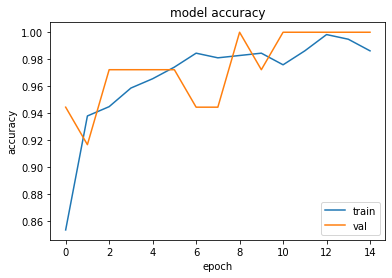

In [23]:
fig_acc = plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')

In [24]:
model2.evaluate(test_set)

3/3 [==============================] - 1s 51ms/step - loss: 0.1992 - accuracy: 0.9783


[0.1992338001728058, 0.97826087474823]

In [25]:
evalPipe=test_set
for feats,lab in evalPipe.unbatch().batch(6000).take(1):
	probPreds=model2.predict(feats)

top1err=tf.reduce_mean(keras.metrics.sparse_top_k_categorical_accuracy(lab,probPreds,k=1))
top5err=tf.reduce_mean(keras.metrics.sparse_top_k_categorical_accuracy(lab,probPreds,k=5))
top10err=tf.reduce_mean(keras.metrics.sparse_top_k_categorical_accuracy(lab,probPreds,k=10))
print(top10err, top5err, top1err)

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.9782609, shape=(), dtype=float32)
